In [1]:
import requests, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path


DATA_FOLDER = Path('C:/Users/calvi/INSY 662_Python/BIXI Project')

In [2]:

model_df = pd.read_csv('BIXI_MODEL.csv')  

In [3]:

model_df['datetime'] = pd.to_datetime(model_df['datetime'], errors='coerce')

### Model 1: Every column EXCEPT historical averages + lags 

#### Multiple Linear Regression Model 1

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


#~ split the dataset using the time

t1, t2 = model_df['datetime'].quantile([0.7, 0.85])

train_df = model_df[model_df['datetime'] <= t1].copy()
val_df   = model_df[(model_df['datetime'] > t1) & (model_df['datetime'] <= t2)].copy()
test_df  = model_df[model_df['datetime'] > t2].copy()

print(f"Train: {len(train_df):,}  Val: {len(val_df):,}  Test: {len(test_df):,}")

Train: 1,029,008  Val: 220,509  Test: 220,367


In [5]:

target = 'total_demand'

numerical_features_m1 = [
    'month',
    'day_of_week',
    'temperature_scaled',
    'wind_speed_scaled',
    'bad_weather',
    'is_weekend',
    'hour_sin',
    'hour_cos',
    'feels_like',
    'is_holiday',
    'temp_hour',
    'temperature_sq',
    'temp_feels_interaction',
    'hour_bucket',
    'weekend_hour_interaction',
    'lat',
    'lon'
]

categorical_features_m1 = ['station']

feature_columns_m1 = numerical_features_m1 + categorical_features_m1

In [6]:

#~ building X/y for each split for model 1

#~ training set
X_train_m1 = train_df[feature_columns_m1]
y_train = train_df[target]

#~ validation set
X_val_m1 = val_df[feature_columns_m1]
y_val = val_df[target]

#~ test set
X_test_m1 = test_df[feature_columns_m1]
y_test = test_df[target]

In [7]:

#~ preprocessing + model 1 pipeline Multi Linear Regression

preprocess_m1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_m1),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_m1)
    ],
    remainder='drop'
)

pipe_m1 = Pipeline([
    ('preprocess', preprocess_m1),
    ('model', LinearRegression())
])

In [8]:

#~ training on training and then evaluating on validation set

pipe_m1.fit(X_train_m1, y_train)

y_train_pred_m1 = pipe_m1.predict(X_train_m1)
y_val_pred_m1   = pipe_m1.predict(X_val_m1)
y_test_pred_m1  = pipe_m1.predict(X_test_m1)

def eval_metrics(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} → R²: {r2:.3f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

eval_metrics("Model 1 – Validation", y_val, y_val_pred_m1)

Model 1 – Validation → R²: 0.432 | MAE: 6.14 | RMSE: 9.18


In [9]:

print("=== MODEL 1 MLR – Overfitting Check (TRAIN-FIT) ===")
eval_metrics("Train",      y_train, y_train_pred_m1)
eval_metrics("Validation", y_val,   y_val_pred_m1)
eval_metrics("Test",       y_test,  y_test_pred_m1)

from sklearn.metrics import r2_score

train_r2_m1 = r2_score(y_train, y_train_pred_m1)
val_r2_m1   = r2_score(y_val,   y_val_pred_m1)
test_r2_m1  = r2_score(y_test,  y_test_pred_m1)

print(f"Generalization Gap (Train - Val):  {train_r2_m1 - val_r2_m1:.3f}")
print(f"Generalization Gap (Train - Test): {train_r2_m1 - test_r2_m1:.3f}")


=== MODEL 1 MLR – Overfitting Check (TRAIN-FIT) ===
Train → R²: 0.458 | MAE: 5.75 | RMSE: 8.55
Validation → R²: 0.432 | MAE: 6.14 | RMSE: 9.18
Test → R²: 0.374 | MAE: 5.34 | RMSE: 7.68
Generalization Gap (Train - Val):  0.026
Generalization Gap (Train - Test): 0.084


In [10]:

#~Combine train + val for final training
X_trval_m1 = pd.concat([X_train_m1, X_val_m1], axis=0)
y_trval_m1 = pd.concat([y_train, y_val], axis=0)

pipe_m1.fit(X_trval_m1, y_trval_m1)

y_test_pred_m1 = pipe_m1.predict(X_test_m1)
eval_metrics("Model 1 – Test", y_test, y_test_pred_m1)


Model 1 – Test → R²: 0.387 | MAE: 5.37 | RMSE: 7.60



##### Plots for interpretability Model 1: MLR 

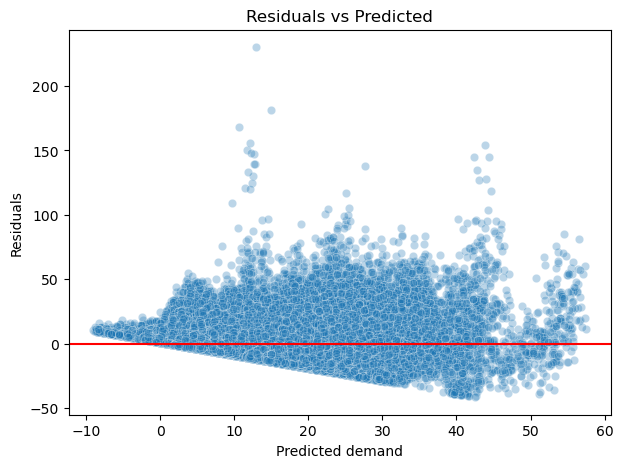

In [11]:

#~ residuals vs predicted plot - Model 1: MLR

residuals = y_val - y_val_pred_m1

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_val_pred_m1, y=residuals, alpha=0.3)
plt.axhline(0, color='red')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted demand")
plt.ylabel("Residuals")
plt.show()

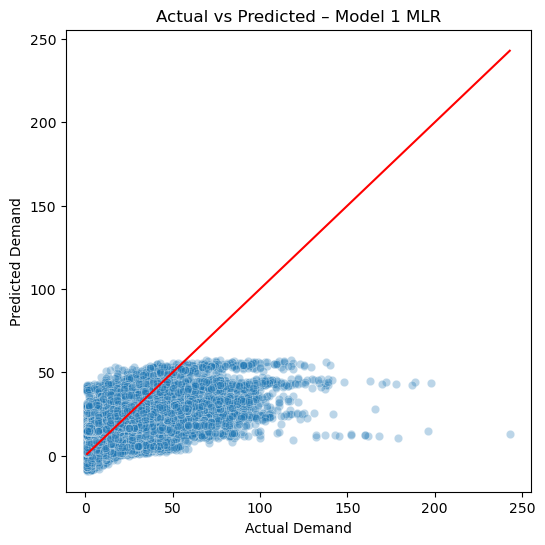

In [12]:

#~ actual vs predicted plot - Model 1L MLR
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_val_pred_m1, alpha=0.3)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         color='red')
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted – Model 1 MLR")
plt.show()


#### Model 1: Random Forest

In [13]:

#~ encoding categorical variables:

model_df['station_encoded'] = model_df['station'].astype('category').cat.codes


In [14]:
t1, t2 = model_df['datetime'].quantile([0.7, 0.85])

train_df = model_df[model_df['datetime'] <= t1].copy()
val_df   = model_df[(model_df['datetime'] > t1) & (model_df['datetime'] <= t2)].copy()
test_df  = model_df[model_df['datetime'] > t2].copy()

print(f"Train: {len(train_df):,},  Val: {len(val_df):,},  Test: {len(test_df):,}")

Train: 1,029,008,  Val: 220,509,  Test: 220,367


In [15]:

#~ Model 1 Feature set Random Forest

target = 'total_demand'

numerical_features_rf_m1 = [
    'month',
    'day_of_week',
    'temperature_scaled',
    'wind_speed_scaled',
    'bad_weather',
    'is_weekend',
    'hour_sin',
    'hour_cos',
    'feels_like',
    'is_holiday',
    'temp_hour',
    'temperature_sq',
    'temp_feels_interaction',
    'hour_bucket',
    'weekend_hour_interaction',
    'lat',
    'lon'
]

categorical_features_rf_m1 = [
    'station_encoded',
]

feature_columns_rf_m1 = numerical_features_rf_m1 + categorical_features_rf_m1


In [16]:

#~ building X / y Random Forest

X_train_rf_m1 = train_df[feature_columns_rf_m1]
y_train    = train_df[target]

X_val_rf_m1   = val_df[feature_columns_rf_m1]
y_val      = val_df[target]

X_test_rf_m1  = test_df[feature_columns_rf_m1]
y_test     = test_df[target]

In [17]:

#~ fit Random Forest Model 1:

from sklearn.ensemble import RandomForestRegressor

rf_m1 = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,            
    min_samples_split=10,    
    min_samples_leaf=5,      
    max_features='sqrt',     
    max_samples=0.7,        
    n_jobs=-1,
    random_state=42
)

rf_m1.fit(X_train_rf_m1, y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', max_samples=0.7,
                      min_samples_leaf=5, min_samples_split=10,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [18]:

#~ evaluating on validation set

y_val_pred_rf_m1 = rf_m1.predict(X_val_rf_m1)

def eval_metrics(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    print(f"{name} → R²: {r2:.3f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

eval_metrics("Model 1 RF – Validation", y_val, y_val_pred_rf_m1)

Model 1 RF – Validation → R²: 0.416 | MAE: 5.85 | RMSE: 9.31


In [19]:

#~ retrain on train + validation, and test on test Model 1: RandomForest


X_trval_rf_m1 = pd.concat([X_train_rf_m1, X_val_rf_m1])
y_trval_rf_m1 = pd.concat([y_train, y_val])

rf_m1.fit(X_trval_rf_m1, y_trval_m1)

y_test_pred_rf_m1 = rf_m1.predict(X_test_rf_m1)
eval_metrics("Model 1 RF – Test", y_test, y_test_pred_rf_m1)

Model 1 RF – Test → R²: 0.372 | MAE: 4.95 | RMSE: 7.69


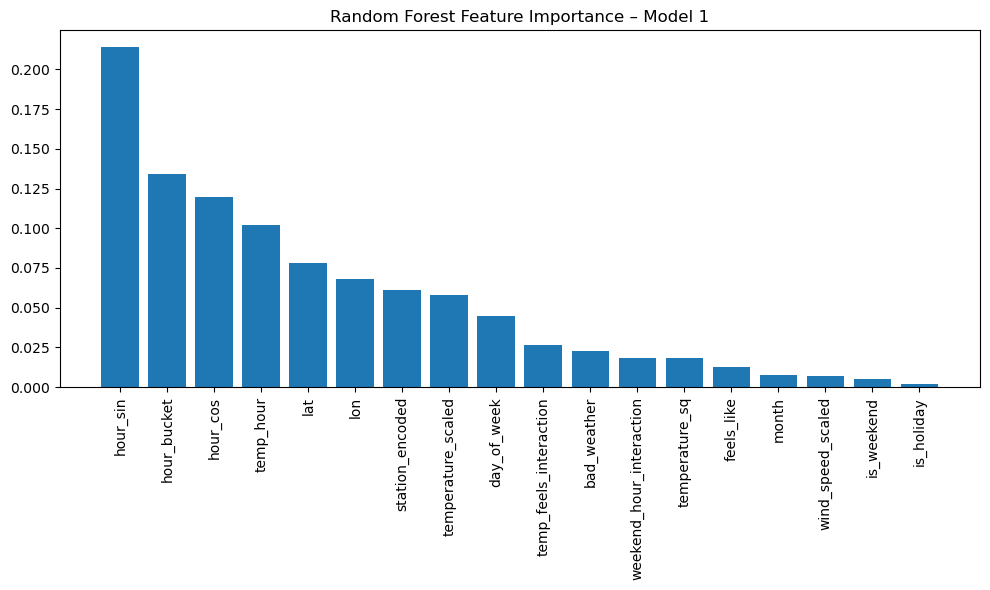

In [20]:

#~ feature importance plot 

importances = rf_m1.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(feature_columns_rf_m1)[indices], rotation=90)
plt.title("Random Forest Feature Importance – Model 1")
plt.tight_layout()
plt.show()

In [21]:

#~ testing for overfitting:


y_train_pred_rf_m1 = rf_m1.predict(X_train_rf_m1)

eval_metrics("Model 1 RF – Train", y_train, y_train_pred_rf_m1)
eval_metrics("Model 1 RF – Val",   y_val,   y_val_pred_rf_m1)
eval_metrics("Model 1 RF – Test",  y_test,  y_test_pred_rf_m1)

train_r2 = r2_score(y_train, y_train_pred_rf_m1)
val_r2   = r2_score(y_val,   y_val_pred_rf_m1)
test_r2  = r2_score(y_test,  y_test_pred_rf_m1)

print("Generalization Gap (Train - Test):", train_r2 - test_r2)



Model 1 RF – Train → R²: 0.456 | MAE: 5.45 | RMSE: 8.57
Model 1 RF – Val → R²: 0.416 | MAE: 5.85 | RMSE: 9.31
Model 1 RF – Test → R²: 0.372 | MAE: 4.95 | RMSE: 7.69
Generalization Gap (Train - Test): 0.08405577511707618


In [22]:
import joblib
import pickle
import numpy as np

# 1. Save the Linear Regression pipeline
joblib.dump(pipe_m1, "model1_mlr_pipeline.pkl")
print("Saved model1_mlr_pipeline.pkl")

# 2. Station metadata
station_meta = (
    model_df[["station", "station_encoded", "lat", "lon"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

stations_sorted = station_meta["station"].sort_values().tolist()
station_to_code = dict(zip(station_meta["station"], station_meta["station_encoded"]))
station_to_lat  = dict(zip(station_meta["station"], station_meta["lat"]))
station_to_lon  = dict(zip(station_meta["station"], station_meta["lon"]))

# 3. Compute scaling params from model_df
temp_mean_raw = model_df["temperature"].mean()
temp_std_raw  = model_df["temperature"].std(ddof=0)

wind_mean_raw = model_df["wind_speed"].mean()
wind_std_raw  = model_df["wind_speed"].std(ddof=0)

print("Temperature mean/std (for scaling):", temp_mean_raw, temp_std_raw)
print("Wind speed mean/std (for scaling):", wind_mean_raw, wind_std_raw)

# 4. Save the Random Forest model
joblib.dump(rf_m1, "model1_rf.pkl")
print("Saved model1_rf.pkl")

# 5. Save metadata for the app
meta = {
    "stations": stations_sorted,
    "station_to_code": station_to_code,
    "station_to_lat": station_to_lat,
    "station_to_lon": station_to_lon,
    "numerical_features_m1": numerical_features_m1,
    "categorical_features_m1": categorical_features_m1,
    "feature_columns_m1": feature_columns_m1,
    "numerical_features_rf_m1": numerical_features_rf_m1,
    "feature_columns_rf_m1": feature_columns_rf_m1,
    "temp_mean": float(temp_mean_raw),
    "temp_std": float(temp_std_raw),
    "wind_mean": float(wind_mean_raw),
    "wind_std": float(wind_std_raw),
}

with open("model1_meta.pkl", "wb") as f:
    pickle.dump(meta, f)

print("Saved model1_meta.pkl")
model_df.to_csv("model_clustering.csv", index=False)

Saved model1_mlr_pipeline.pkl
Temperature mean/std (for scaling): 19.179398714456386 5.938499824457523
Wind speed mean/std (for scaling): 14.425536300823739 7.087536429155381
Saved model1_rf.pkl
Saved model1_meta.pkl
